In [ ]:
import keras_tuner
import numpy as np
import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
import Modules.constants as constants
import Modules.ds_loader as ds_loader

SAMPLE_PERCENTAGE = 1.0

DATA_PATH = constants.DATASET
TRAIN_DIR = DATA_PATH / "train"
VAL_DIR = DATA_PATH / "val"
TEST_DIR = DATA_PATH / "test"

X_train, y_train = ds_loader.load_all_data(TRAIN_DIR, SAMPLE_PERCENTAGE)
X_val, y_val = ds_loader.load_all_data(VAL_DIR, SAMPLE_PERCENTAGE)
X_test, y_test = ds_loader.load_all_data(TEST_DIR, SAMPLE_PERCENTAGE)

In [30]:
print("Unique classes in y:", np.unique(y_train))
print("Datatype:", print(X_train.dtype), print(y_train.dtype))
print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)
print(f"Min and Max of X_train: {np.min(X_train)}, {np.max(X_train)}")
print(f"Min and Max of X_test: {np.min(X_test)}, {np.max(X_test)}")
print(f"Min and Max of X_val: {np.min(X_val)}, {np.max(X_val)}")
print(f"NaNs in X: {np.isnan(X_train).sum()}")
print(f"Infs in X: {np.isinf(X_train).sum()}")

Unique classes in y: [0 1 2 3]
float32
int32
Datatype: None None
(8502, 250, 12) (532, 250, 12) (1594, 250, 12)
(8502,) (532,) (1594,)
Min and Max of X_train: 0.0, 1.0000001192092896
Min and Max of X_test: -12.73619556427002, 10.190157890319824
Min and Max of X_val: -15.227375984191895, 14.855135917663574
NaNs in X: 0
Infs in X: 0


In [31]:
class RNN(keras_tuner.HyperModel):
    def build(self, hp):
        # Define Input layer
        inputs = tf.keras.layers.Input(shape=(250, 12), dtype="float32")
        
        # First Bidirectional GRU Layer
        x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
            units=hp.Int('gru_1_units', min_value=32, max_value=256, step=32),
            return_sequences=True
        ))(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.05))(x)

        # Second Bidirectional GRU Layer
        x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
            units=hp.Int('gru_2_units', min_value=32, max_value=128, step=16),
            return_sequences=False
        ))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.05))(x)

        # Dense layer
        x = tf.keras.layers.Dense(
            units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
            activation='relu'
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.3, step=0.05))(x)

        # Output layer (4 classes)
        outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

        # Optimizer 
        optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd'])
        
        if optimizer_choice == 'adam':
            optimizer = tf.keras.optimizers.Adam(
                learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')
            )
        elif optimizer_choice == 'sgd':
            optimizer = tf.keras.optimizers.SGD(
                learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG'),
                momentum=hp.Float('momentum', min_value=0.0, max_value=0.9, step=0.05)
            )

        model = tf.keras.Model(inputs, outputs)
        
        model.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            epochs=hp.Int("epochs", 5, 50),
            batch_size=hp.Choice("batch_size", [8, 16, 32]),
            *args,
            **kwargs,
        )

In [32]:
tuner = keras_tuner.RandomSearch(
    RNN(),
    max_trials=30,
    objective='val_loss',
    directory="Results/GRU",
    project_name="ECGClassification",
    )
tuner.search_space_summary()

Reloading Tuner from Results/GRU/ECGClassification/tuner0.json
Search space summary
Default search space size: 11
gru_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
gru_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout_3 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.05, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
learning_rate (Float)
{'default': 1e-05, 

In [ ]:
callback_list = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=0),
]

tuner.search(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    callbacks=callback_list 
)

Trial 13 Complete [00h 04m 03s]
val_loss: 1.706668734550476

Best val_loss So Far: 0.2646099030971527
Total elapsed time: 01h 39m 45s

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
32                |160               |gru_1_units
0.25              |0.4               |dropout_1
96                |96                |gru_2_units
0.45              |0.25              |dropout_2
32                |32                |dense_units
0.2               |0.2               |dropout_3
adam              |adam              |optimizer
1.0486e-05        |0.0006074         |learning_rate
16                |47                |epochs
16                |16                |batch_size
0.35              |0.85              |momentum

Epoch 1/16
532/532 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.2385 - loss: 2.0561 - val_accuracy: 0.2327 - val_loss: 1.4902
Epoch 2/16
330/532 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.2542 - loss: 1.8870

In [ ]:
tuner.results_summary()

Results summary
Results in RESULTS/GRU/ECGClassification
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 09 summary
Hyperparameters:
gru_1_units: 160
dropout_1: 0.4
gru_2_units: 96
dropout_2: 0.25
dense_units: 32
dropout_3: 0.2
optimizer: adam
learning_rate: 0.0006073973849810032
epochs: 47
batch_size: 16
momentum: 0.8500000000000001
Score: 0.2646099030971527

Trial 03 summary
Hyperparameters:
gru_1_units: 256
dropout_1: 0.2
gru_2_units: 80
dropout_2: 0.30000000000000004
dense_units: 64
dropout_3: 0.2
optimizer: adam
learning_rate: 0.00013868016325519167
epochs: 23
batch_size: 8
momentum: 0.2
Score: 0.325541228055954

Trial 05 summary
Hyperparameters:
gru_1_units: 256
dropout_1: 0.45
gru_2_units: 32
dropout_2: 0.4
dense_units: 16
dropout_3: 0.25
optimizer: adam
learning_rate: 0.0003842350752244457
epochs: 47
batch_size: 8
momentum: 0.6000000000000001
Score: 0.3586284816265106

Trial 01 summary
Hyperparameters:
gru_1_units: 32
dropout_1: 0.30000000000000004
gru

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()
best_model.save("best_model_rnn.keras") 

/home/capitan/.venv/tenv/lib64/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 250, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 250, 320)       │       167,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 250, 320)       │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 250, 320)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 192)            │       240,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 192)            │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 416,292 (1.59 MB)

 Trainable params: 415,204 (1.58 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8898 - loss: 0.3612
Test Loss: 0.2816593050956726
Test Accuracy: 0.9191729426383972


In [ ]:
y_pred = best_model.predict(X_test)

if y_pred.shape[1] == 1:  
    y_pred_binary = (y_pred > 0.5).astype(int)
    auc = sklearn.metrics.roc_auc_score(y_test, y_pred)  
else:
    y_pred_binary = np.argmax(y_pred, axis=1)  
    auc = sklearn.metrics.roc_auc_score(y_test, y_pred, multi_class='ovr')

print("Classification Report (Test Data):")
print(sklearn.metrics.classification_report(y_test, y_pred_binary))
print(f"AUC: {auc}")

y_train_pred = best_model.predict(X_train)
y_train_pred = np.argmax(y_train_pred, axis=1)

print("Classification Report (Train Data):")
print(sklearn.metrics.classification_report(y_train, y_train_pred))


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       111
           1       0.81      0.94      0.87       115
           2       0.98      0.96      0.97       195
           3       0.96      0.91      0.94       111

    accuracy                           0.92       532
   macro avg       0.91      0.91      0.91       532
weighted avg       0.92      0.92      0.92       532

AUC: 0.9829726713025733
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Classification Report (Train Data):
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1774
           1       0.94      0.91      0.93      1840
           2       0.98      0.98      0.98      3110
           3       0.96      0.94      0.95      1778

    accuracy                           0.95      8502
   macro avg       0.94      0.94      0.94      8502
weighted

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0] 
print(best_hps.values)

{'gru_1_units': 160, 'dropout_1': 0.4, 'gru_2_units': 96, 'dropout_2': 0.25, 'dense_units': 32, 'dropout_3': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0006073973849810032, 'epochs': 47, 'batch_size': 16, 'momentum': 0.8500000000000001}


## MANUAL ADJUSTMENTS

#### Hand-tune the best candidate model here if slight changes will make a difference

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0] 
modified_hps = best_hps.copy()

# HERE IS AN EXAMPLE
#modified_hps.values['c_units'] = 16
#modified_hps.values['k_units'] = 5 
#best_model = Resnet().build(modified_hps)
#best_model = Resnet().build(best_hps)

best_model = RNN().build(best_hps)
 
history = best_model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=16
    )


Epoch 1/70
532/532 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.3459 - loss: 1.5881 - val_accuracy: 0.3407 - val_loss: 1.4743
Epoch 2/70
532/532 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.4193 - loss: 1.3100 - val_accuracy: 0.3877 - val_loss: 1.7140
Epoch 3/70
532/532 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.5234 - loss: 1.1053 - val_accuracy: 0.4787 - val_loss: 1.7388
Epoch 4/70
532/532 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.6682 - loss: 0.8163 - val_accuracy: 0.5295 - val_loss: 1.6941
Epoch 5/70
532/532 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.7413 - loss: 0.6775 - val_accuracy: 0.7472 - val_loss: 0.7371
Epoch 6/70
532/532 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.8304 - loss: 0.4764 - val_accuracy: 0.8074 - val_loss: 0.5091
Epoch 7/70
532/532 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.8533 - loss: 0.4196 - val_accuracy: 0.8639 - val_loss: 0.3730
Epoch 8/70
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8766 - loss: 0.3630 - 

In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, batch_size=16)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8319 - loss: 0.8206
Test Loss: 0.46737098693847656
Test Accuracy: 0.9041353464126587


In [ ]:
y_pred = best_model.predict(X_test)

if y_pred.shape[1] == 1:  
    y_pred_binary = (y_pred > 0.5).astype(int)
    auc = sklearn.metrics.roc_auc_score(y_test, y_pred)  
else:
    y_pred_binary = np.argmax(y_pred, axis=1)  
    auc = sklearn.metrics.roc_auc_score(y_test, y_pred, multi_class='ovr')

print("Classification Report (Test Data):")
print(sklearn.metrics.classification_report(y_test, y_pred_binary))
print(f"AUC: {auc}")

y_train_pred = best_model.predict(X_train)
y_train_pred = np.argmax(y_train_pred, axis=1)

print("Classification Report (Train Data):")
print(sklearn.metrics.classification_report(y_train, y_train_pred))


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       111
           1       0.73      0.97      0.83       115
           2       0.97      0.99      0.98       195
           3       0.98      0.89      0.93       111

    accuracy                           0.90       532
   macro avg       0.92      0.89      0.89       532
weighted avg       0.92      0.90      0.90       532

AUC: 0.9814308316976486
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Classification Report (Train Data):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1774
           1       0.96      0.98      0.97      1840
           2       0.99      1.00      0.99      3110
           3       0.99      0.96      0.97      1778

    accuracy                           0.98      8502
   macro avg       0.98      0.98      0.98      8502
weighted

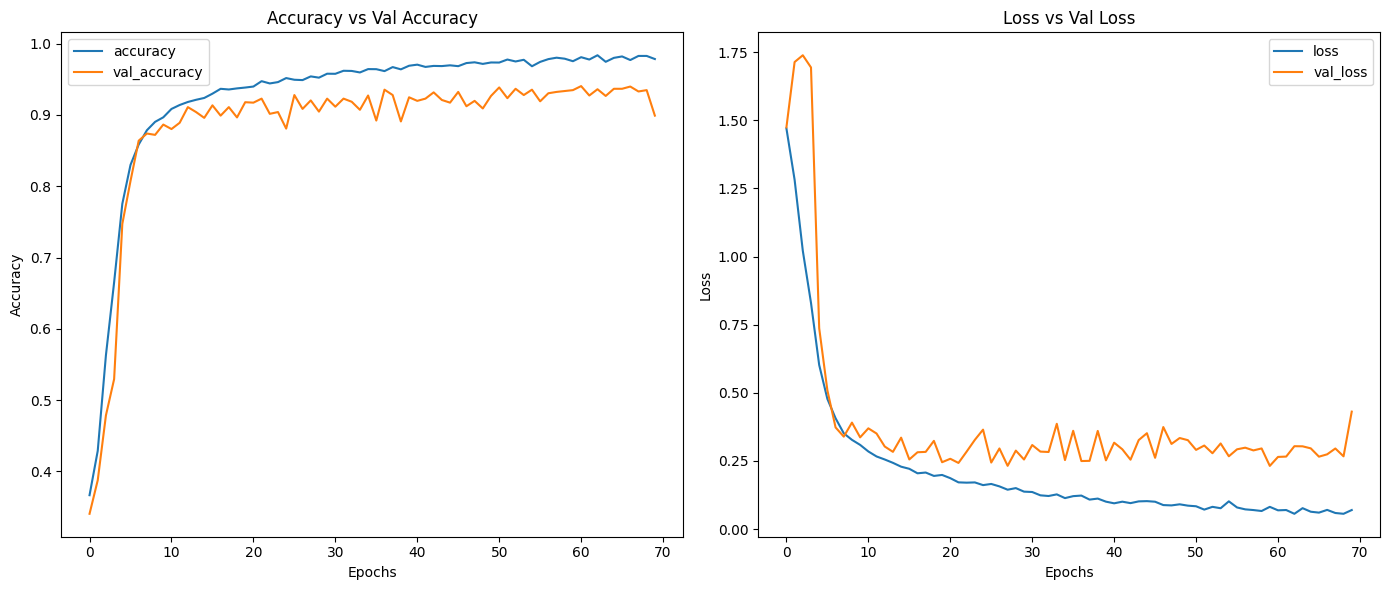

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(history.history['accuracy'], label='accuracy')
ax[0].plot(history.history['val_accuracy'], label='val_accuracy')
ax[0].set_title('Accuracy vs Val Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='loss')
ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].set_title('Loss vs Val Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()